# Multi-label classification -- ranking loss

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import itertools

from scipy.io import arff
from scipy.optimize import minimize
from scipy.optimize import check_grad

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from evaluate import avgPrecision, avgPrecisionK, printEvaluation

In [3]:
data_dir = 'data'
yeast_ftrain = os.path.join(data_dir, 'yeast/yeast-train.arff')
yeast_ftest  = os.path.join(data_dir, 'yeast/yeast-test.arff')

In [4]:
SEED = 123456789

## Data loading

Load yeast dataset.

In [5]:
data_train, meta_train = arff.loadarff(yeast_ftrain)

In [6]:
data_test, meta_test = arff.loadarff(yeast_ftest)

In [7]:
type(data_train)

numpy.ndarray

In [8]:
#print(data_train[0])

In [9]:
len(list(data_train[0]))

117

Features

In [10]:
nFeatures = np.array(list(data_train[0])[:-14], dtype=np.float).shape[0]
print('#features:', nFeatures)

#features: 103


In [11]:
#np.array(list(data_train[0])[:-14], dtype=np.float)

Labels

In [12]:
nLabels = np.array(list(data_train[0])[-14:], dtype=np.int).shape[0]
print('#labels:', nLabels)

#labels: 14


In [13]:
#np.array(list(data_train[0])[-14:], dtype=np.int)

## Data analysis

In [14]:
print('#training examples:', len(data_train))

#training examples: 1500


In [15]:
print('#test examples:', len(data_test))

#test examples: 917


Histogram of #positive labels.

In [16]:
nPositives = [np.sum(np.array(list(data_train[ix])[-14:], dtype=np.int)) for ix in range(len(data_train))]

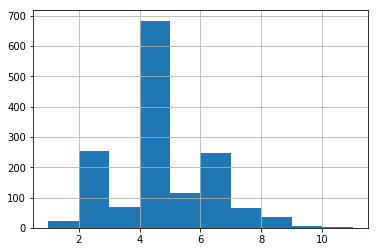

In [17]:
pd.Series(nPositives).hist(bins=10)

## Dataset creation

In [18]:
def create_dataset(data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              Y comprises the labels of the corresponding example
    """

    N = len(data)
    D = nFeatures
    L = nLabels

    magic = -14

    X = np.zeros((N, D), dtype = np.float)
    Y = np.zeros((N, L), dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:magic]
        Y[i, :] = list(data[i])[magic:]

    return X, Y

The sigmoid function.

In [19]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

## Ranking loss

Multi-label learning with ranking loss.

In [20]:
def obj_ranking(w, X, Y, C):
    """
        Objective with L2 regularisation and ranking loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant, is consistent with scikit-learn C = 1 / (N * \lambda)
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    
    W = w.reshape(L, D)  # reshape weight matrix    
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for n in range(N):
        Jn = 0.0
        Gn = np.zeros_like(W)
        x = X[n, :]
        y = Y[n, :]
        nPos = np.sum(y)   # num of positive examples
        nNeg = L - nPos    # num of negative examples
        denom = nPos * nNeg
        
        ixPos = np.nonzero(y)[0].tolist()               # indices positive examples
        ixNeg = list(set(np.arange(L)) - set(ixPos))    # indices negative examples
        
        ixmat = np.array(list(itertools.product(ixPos, ixNeg)))  # shape: ixPos*ixNeg by 2
        dW = W[ixmat[:, 0], :] - W[ixmat[:, 1], :]
        sVec = np.dot(dW, x)
        Jn = np.sum(np.log1p(np.exp(-sVec)))
        
        coeffVec = np.divide(1, 1 + np.exp(sVec))
        coeffPos = pd.DataFrame(coeffVec)
        coeffPos['gid'] = ixmat[:, 0]
        coeffPos = coeffPos.groupby('gid', sort=False).sum()
        coeffNeg = pd.DataFrame(coeffVec)
        coeffNeg['gid'] = ixmat[:, 1]
        coeffNeg = coeffNeg.groupby('gid', sort=False).sum()
        
        #print(coeffPos)
        #print(coeffNeg)
        
        coeffs = np.ones(L)
        coeffs[ixPos] = -coeffPos.loc[ixPos].values.squeeze()
        coeffs[ixNeg] = coeffNeg.loc[ixNeg].values.squeeze()
        
        #print(coeffs)
        Gn = np.tile(x, (L, 1)) * coeffs[:, None]
                        
        J += Jn / denom
        G = G + Gn / denom
        
    #J = 0.5 * C * np.dot(w, w) + J / N
    #G = C * W + G / N
    
    # be consistent with scikit-learn C = 1 / (N * \lambda)
    J = 0.5 * np.dot(w, w) + C * J
    G = W + C * G
    
    return (J, G.ravel())

Check gradient

In [21]:
X_train, Y_train = create_dataset(data = data_train)
X_test,  Y_test  = create_dataset(data = data_test)

In [22]:
#%%script false
C = 1
w0 = np.random.rand(nFeatures * nLabels)
check_grad(lambda w: obj_ranking(w, X_train[:10], Y_train[:10], C)[0], \
           lambda w: obj_ranking(w, X_train[:10], Y_train[:10], C)[1], w0)

4.0934923411084561e-05

In [23]:
class MLC_ranking(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, C=1):
        """Initialisation"""
        
        assert C > 0
        self.C = C
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        
        opt_method = 'BFGS' #'Newton-CG'
        options = {'disp': True}
        if options['disp']: 
            print('\nC: %g' % self.C)
            
        D = X_train.shape[1]
        L = Y_train.shape[1]
        w0 = np.random.rand(L * D)  # initial guess
        opt = minimize(obj_ranking, w0, args=(X_train, Y_train, self.C), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.w = opt.x
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            self.trained = False
    
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.w.reshape(-1, D).T)
        
    
    def predict(self, X_test):
        """Make predictions (score is boolean)"""
        
        preds = self.decision_function(X_test)
        return (preds > 0)
    
    
    def score(self, X, Y):
        """Compute scoring metric"""
        
        allPreds = self.decision_function(X)
        return avgPrecisionK(Y, allPreds)
    
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [24]:
#parameters = [{'C': [10**(e) for e in range(-6,7)]}]
parameters = [{'C': [10**(e) for e in range(-6,1)]}]

clf = GridSearchCV(MLC_ranking(), parameters, cv=5)
clf.fit(X_train, Y_train)

print("\nBest parameters set found on development set:")
print(clf.best_params_)


C: 1e-06
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-05
Optimization terminated successfully.
         Current function value: 0.008318
         Iterat

In [25]:
for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], \
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.488 (+/-0.038) for {'C': 1e-06}
0.487 (+/-0.038) for {'C': 1e-05}
0.488 (+/-0.037) for {'C': 0.0001}
0.488 (+/-0.038) for {'C': 0.001}
0.488 (+/-0.034) for {'C': 0.01}
0.490 (+/-0.031) for {'C': 0.1}
0.485 (+/-0.031) for {'C': 1}


In [26]:
preds_train = clf.decision_function(X_train)
preds_test  = clf.decision_function(X_test)

In [27]:
print('Training set:')
printEvaluation(Y_train, preds_train)
print()
print('Test set:')
printEvaluation(Y_test, preds_test)

Training set:
Average Precision@K: 0.5237, 0.008

Test set:
Average Precision@K: 0.4870, 0.010


## Result analysis

In [28]:
precisions_train = [avgPrecision(Y_train, preds_train, k) for k in range(1, nLabels+1)]
precisions_test  = [avgPrecision(Y_test,  preds_test,  k) for k in range(1, nLabels+1)]

In [29]:
precisionK_train = avgPrecisionK(Y_train, preds_train)
precisionK_test  = avgPrecisionK(Y_test,  preds_test)

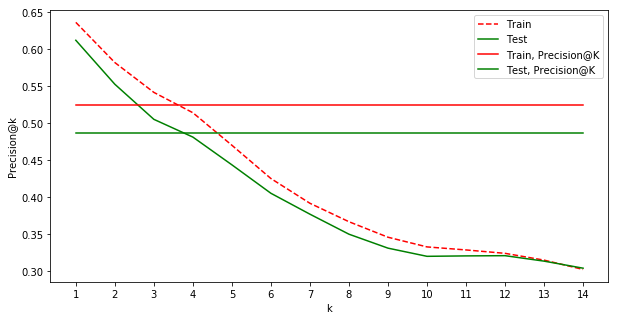

In [30]:
plt.figure(figsize=[10,5])
plt.plot(precisions_train, ls='--', c='r', label='Train')
plt.plot(precisions_test,  ls='-',  c='g', label='Test')
plt.plot([precisionK_train for k in range(nLabels)], ls='-', c='r', label='Train, Precision@K')
plt.plot([precisionK_test  for k in range(nLabels)], ls='-', c='g', label='Test, Precision@K')
plt.xticks(np.arange(nLabels), np.arange(1,nLabels+1))
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.legend(loc='best')